## LSTM with Attention and Noise in S&P500 Direction Prediction 

## Feature Engineering


*   The fourth project is the development of a notebook (code + explanation) that successfully engineers 12 unique types of features, **three** for each type of feature engineering: **transforming**, **interacting**, **mapping**, and **extracting**.
* The second part of the assignment is the development of a **deep learning classification** model to predict the direction of the S&P500 for the dates **2018-01-01—2018-07-12** (test set).
* The feature engineering section is unrelated to the model section, you can develop any features, not just features that would work for deep learning models (later on you can decide which features to use in your model).
*  You also have to uncomment all the example features and make them run successfully  → **every** feature example has some error/s that you have to fix. Please also describe the error you fixed!
*   Note that we *won't* be attempting to measure the quality of every feature (i.e., how much it improves the model), that is slightly too advanced for this course.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor

import torch
from torch import tensor
from torch import nn
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import time

import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')


Preparing the Data

In [129]:
# preparing our data
raw_prices = pd.read_csv("https://storage.googleapis.com/sovai-public/random/assetalloc.csv", sep=';', parse_dates=True, index_col='Dates', dayfirst=True)
df = raw_prices.sort_values(by='Dates')
df["target"] = df["SP500"].pct_change().shift(-1)
df["target"] = np.where(df["target"]>0,1,0)
df.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB,target
Dates,,,,,,,,,,,,,,,,,,
1989-02-01,2039.7,875.47,297.09,392.50,99.081,99.039,99.572,100.000,100.031,100.345,101.080,101.936,154.38,117.50,1636.57,133.584,286.67,0
1989-02-02,2043.4,878.08,296.84,392.00,98.898,99.117,99.278,99.692,100.000,100.314,101.017,101.905,154.94,117.69,1642.94,135.052,287.03,1
1989-02-03,2069.9,884.09,296.97,388.75,98.907,99.002,99.145,99.178,99.812,100.062,100.921,101.718,155.69,118.62,1659.11,137.134,285.63,0
1989-02-06,2044.3,885.49,296.04,388.00,98.484,98.502,98.510,97.739,99.812,100.062,100.794,101.468,155.58,118.89,1656.86,137.037,284.69,1
1989-02-07,2072.8,883.82,299.63,392.75,98.438,98.312,98.292,97.688,99.906,100.251,101.144,102.092,156.84,118.28,1662.76,136.914,284.21,0




### First Train Test Split, then split training set into train and validation


In [130]:
from sklearn.model_selection import train_test_split
df1 = df.copy()
y = df1.pop("target")
X = df1.copy()

X_train = X[X.index.astype(str)<'2018-01-01']
y_train = y[X_train.index]
X_test = X[~X.index.isin(X_train.index)]
y_test = y[X_test.index]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [131]:
num_samples = len(X_train)
train_size = int(num_samples * 0.6)
valid_size = num_samples - train_size

X_train_df = X_train.iloc[:train_size]
y_train_df = y_train.iloc[:train_size]

X_valid_df = X_train.iloc[-valid_size:]
y_valid_df = y_train.iloc[-valid_size:]


### Transforming

1. Refresh your mind on tranformation methods by going back to the material. I am simply providing 1 example here.
1. Don't repeat my logarithmic return calculation, develop your own transformation (there are 1000s of types of transformations).
1. In the example I provide, there is also an error that you have to fix. For example, one of the errors below is that you should actually use `np.log1p()`, but there is another one, so watch out!

Problem: the transformation to train and validation dataset cause huge differnece in some featrues' range.

Reason: I only consider feature distribution in df, but the distribution in train and validation are different, differnet distribution with same transformation will cause range varies hugely in same feature from different dataset.

Solve: Check each feature distribution's shape and data range from train and valid distribution seperately.If same feature shwos similiar distribution in differnt datasets, use specific transformation according to that distribution. If the distribution is differnet in datasets, just scale them instead of transform them, or use different transformation specifically.

Detials: move MSCI_EM out from square transformation, move FISE, French-5Y and CRB out from boxcox transformation.

In [6]:
def inspect_columns(df):

    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

inspect_columns(df)

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
FTSE,False,7259,False,0.0,2039.700,2533.100,7651.330,float64
EuroStoxx50,False,7504,False,0.0,875.470,1081.980,3445.493,float64
SP500,False,7197,False,0.0,297.090,404.440,2798.290,float64
Gold,False,5225,False,0.0,392.500,349.700,1247.320,float64
French-2Y,False,5174,False,0.0,99.081,98.702,89.925,float64
French-5Y,False,6401,False,0.0,99.039,99.375,149.023,float64
French-10Y,False,6723,False,0.0,99.572,100.458,211.724,float64
French-30Y,False,6661,False,0.0,100.000,102.160,305.707,float64
US-2Y,False,4337,False,0.0,100.031,105.247,122.683,float64
US-5Y,False,6010,False,0.0,100.345,108.370,143.723,float64


In [7]:
df.describe()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB,target
count,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000,7682.000000
mean,4963.027135,2676.173213,1158.608469,699.251304,103.851192,125.639842,139.493888,170.176966,114.683909,126.287628,125.313396,133.803908,607.680260,151.079944,2865.501070,628.805674,333.979130,0.517574
std,1542.440297,1093.593906,588.816044,456.205247,4.651301,18.055983,32.718964,59.922221,8.245838,16.734645,16.605920,21.411653,363.377082,48.682885,1157.500615,315.914953,95.804692,0.499724
min,1990.200000,818.500000,287.110000,252.850000,89.925000,91.211000,88.147000,80.873000,98.684000,97.479000,97.361000,96.579000,118.820000,76.890000,1093.520000,133.584000,205.620000,0.000000
25%,3727.525000,1637.457500,657.795000,350.775000,101.253750,112.337750,118.374000,124.697750,108.046000,112.711250,112.618000,117.291000,333.782500,112.041500,1933.072500,348.189250,250.762500,0.000000
50%,5290.915000,2795.350000,1149.775000,400.350000,104.839000,125.603000,134.802500,160.969000,112.918000,120.744000,120.574000,130.331000,510.550000,138.530000,2696.885000,513.179500,294.740000,1.000000
75%,6210.170000,3448.370250,1417.252500,1178.305000,107.470000,140.479250,153.394000,195.394250,124.067500,143.552500,139.496500,146.128750,793.025000,188.859500,3412.010000,952.422000,422.370000,1.000000
max,7877.450000,5464.430000,2872.870000,1898.250000,111.218000,157.860000,217.376000,345.245000,126.921000,156.652000,163.328000,195.414000,1706.990000,279.741000,6048.960000,1338.487000,580.490000,1.000000


In [8]:
# Plotting PDFs for each variable in a 4x4 grid with the last subplot empty
def plot(df):
  num_vars = len(df.columns)
  num_rows = 5
  num_cols = 4
  num_subplots = num_rows * num_cols

  plt.figure(figsize=(20, 15))

  for i, column in enumerate(df.columns):
      if i < num_subplots:
          plt.subplot(num_rows, num_cols, i + 1)
          sns.histplot(df[column], kde=True, stat="density", linewidth=0)
          plt.title(column)
          plt.ylabel('Density')

  plt.tight_layout()
  plt.show()

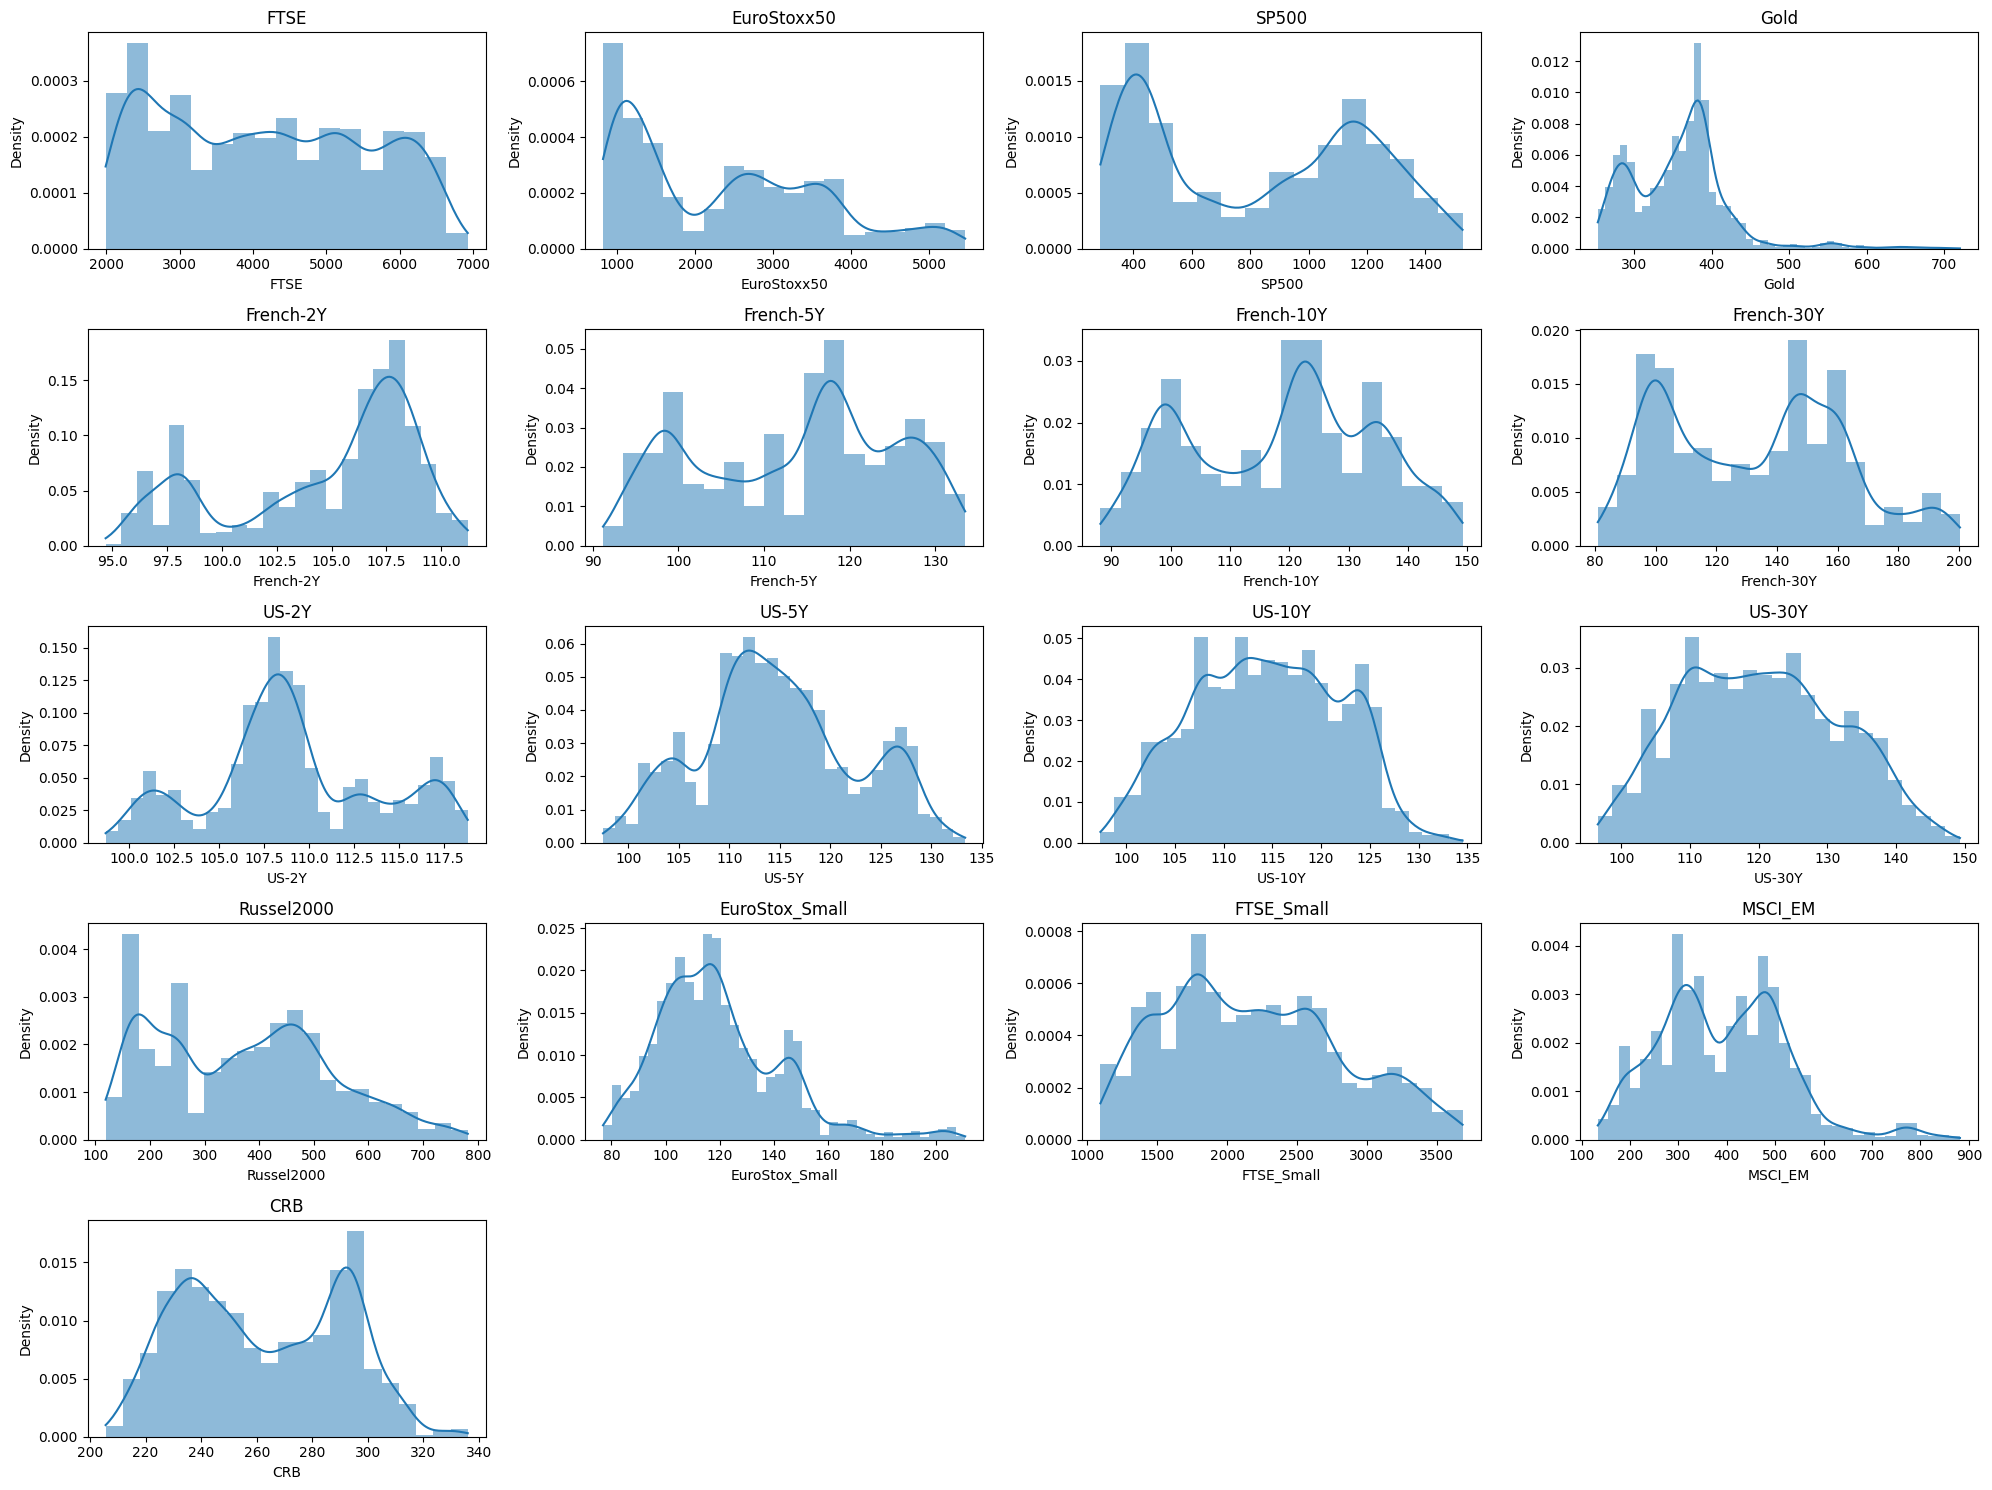

In [9]:
plot(X_train_df)

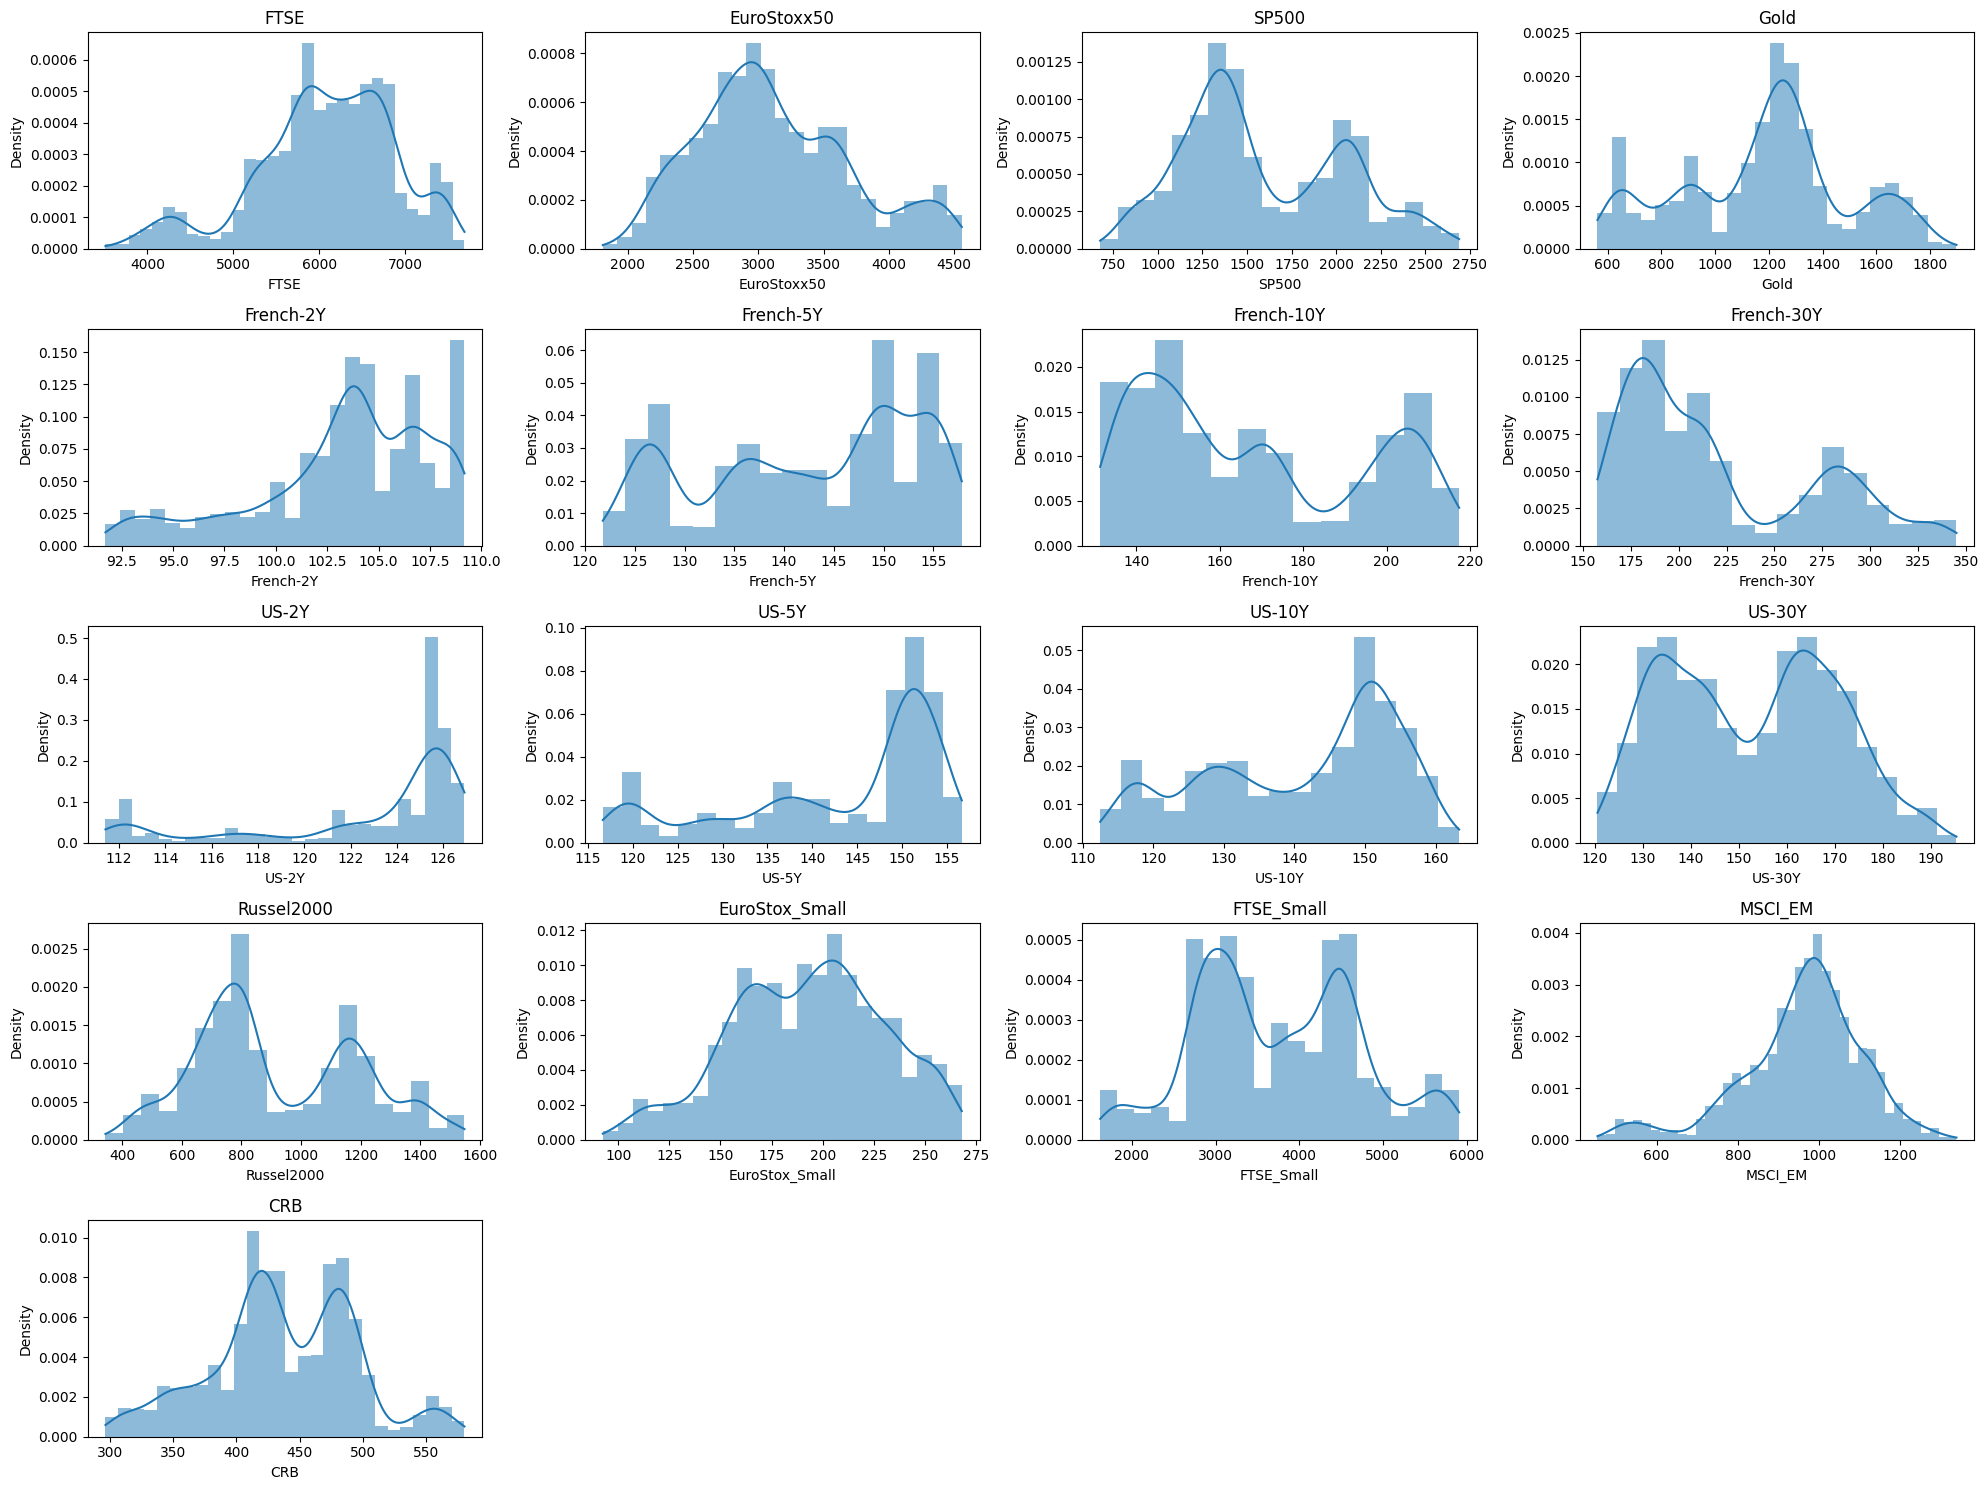

In [ ]:
plot(X_valid_df)

In [ ]:
def fillmean(df, cols):
    for col in cols:
        mean_val = df[col].mean()
        df[col] = df[col].fillna(mean_val)
    return df

In [ ]:
# check if df includes na or infinity, and specify that column
def check_for_nans(df):

    if df.isna().any().any():

        nan_columns = df.columns[df.isna().any()].tolist()
        msg = f"Columns with NaN values: {nan_columns}"
    else:
        msg = "The DataFrame does not contain any NaN values."

    return msg

def check_for_inf(df):

    if df.isin([np.inf, -np.inf]).any().any():
        inf_columns = df.columns[df.isin([np.inf, -np.inf]).any()].tolist()
        msg = f"Columns with infinity values: {inf_columns}"
    else:
        msg = "The DataFrame does not contain any infinity values."

    return msg

def locate_inf(df):
    # Create a mask where infinity values are marked as True
    inf_mask = df.isin([np.inf, -np.inf])

    # Use the mask to locate rows and columns with infinity values
    rows_with_inf = inf_mask.any(axis=1)
    columns_with_inf = inf_mask.any(axis=0)

    # Locate positions of infinity values
    positions = [(index, col) for index, row in inf_mask.iterrows() if row.any() for col in df.columns[row]]

    return positions


In [132]:
# Example Transforming (has errors)

# Name: Logarithmic return of FTSE
# Description: Developing the logarithmic return feature for use within linear models that make normality assumptions.

# df["FTSE_log"] = np.log(df["FTSE"])

df_=df.copy()
df_["FTSE_log"] = np.log1p(df_["FTSE"] / df_["FTSE"].shift(1))
check_for_nans(df_)
fillmean(df_,['FTSE_log'])
check_for_nans(df_)
# df_

'The DataFrame does not contain any NaN values.'

Error1: np.log cannot be applied to 0 or negative number, so if df["FTSE"] contains 0 or number very close to 0, the function cannot properly work.

Solve: change np.log(df["FTSE"]) to df["FTSE_log"] = np.log(df["FTSE"] + 1e-10 ) or use np.log1p(x) which calculates the natural logarithm of 1 + x.

Error2: The code doesn't actually calculate the return of "FTSE". The  logarithmic return calculates  natural logarithm of the ratio of successive prices.

Solve: change code to df["FTSE_log_return"] = np.log(df["FTSE"] / df["FTSE"].shift(1)).

Error3: the shift calculation will cause the first raw NAN.

Solve: use fillmean to fill the na.

Note:  Use the same scaler that was fitted on the training data to transform the test data. This ensures that the test data is scaled using the same parameters as the training data, preserving the integrity of the test set.

In [29]:
# Transforming 1.
# Square root of cols_sqrt
# to resduce right skewness of Gold, french10,30, russel2000, EuroStock_small, FISE small
cols_sqrt = ['Gold', 'French-10Y', 'French-30Y', 'Russel2000', 'EuroStox_Small', 'FTSE_Small']

def sqrt(df, cols):
  for col in cols:
    df[col+"_sqrt"] = np.sqrt(df[col])

  return df

X_train_df = sqrt(X_train_df, cols_sqrt)
X_valid_df = sqrt(X_valid_df, cols_sqrt)

In [30]:
# Transforming 2.
# squre of cols_square
#  "MSCI_EM" in train has a distribution with high values on both sides and low values in the middle, indicating a bimodal or U-shaped distribution.
# In such cases,  Squaring values can help spread out the distribution and make it more symmetric.
# However, the shape of "MSCI_EM" is different in valid dataset, so we just square US bond to make it more symmetric.
cols_squre = ['US-2Y', 'US-5Y', 'US-10Y']

def square(df, cols):
  for col in cols:
    df[col+"_square"] = df[col] ** 2

  return df

X_train_df = square(X_train_df, cols_squre)
X_valid_df = square(X_valid_df, cols_squre)

In [31]:
# Transforming 3.
# Box-Cox transformation of cols_boxcox
# Use boxcox for making variables more normal distributed, less impact by extrame values in tails, make the data more normally distributed,
# and automatically choose transformation methods for variables uncertain to transfer

# move FISE, French-5Y and CRB out from boxcox
# cols_boxcox = X_train_df.columns[~X_train_df.columns.isin(cols_sqrt) & ~X_train_df.columns.isin(cols_squre) & ~X_train_df.columns.isin(['FTSE', 'French-5Y', 'CRB', 'MSCI_EM'])]
cols_boxcox = ['EuroStoxx50', 'SP500', 'French-2Y', 'US-30Y']
def boxcox(df, cols):
  for col in cols:
    df[col+"_bc"], lambda_best_fit = stats.boxcox(df[col])

  return df

X_train_df = boxcox(X_train_df, cols_boxcox)
X_valid_df = boxcox(X_valid_df, cols_boxcox)

# ValueError: Array conditional must be same shape as self
# reason: try to perform an operation on a DataFrame using conditions that don't have the same shape as the DataFrame.
# solve: change cols_boxcox = df.where(~df.columns.isin(cols_sqrt) & ~df.columns.isin(cols_squre), other=None) to X_train_df.columns[~X_train_df.columns.isin(cols_sqrt) & ~X_train_df.columns.isin(cols_squre)]

In [33]:
# LSTM models are sensitive to the scale of input data
# after applying different transformations to different variables, scale them into same range [0,1], as all variables are postive
# however, the data in training and validation dataset has very wide range such as features FTSE, MSCI_EM and so on, which causes MaxMin and standard scaler fail to scale features within range [0,1] or [-1,1]
# apply norm='l2' with Robust Scaler to ensure that each feature vector has a unit norm, when dealing with features of varying magnitudes and units.

from sklearn.preprocessing import RobustScaler, normalize

# Create a RobustScaler and fit it on the training data
scaler = RobustScaler()
scaler.fit(X_train_df)  # only fit train set in scaler

# Transform both the training and validation data using the same scaler
X_train_df_scaled = scaler.transform(X_train_df)
X_valid_df_scaled = scaler.transform(X_valid_df)

# Apply L2 normalization to the scaled data
X_train_df_normalized = normalize(X_train_df_scaled, norm='l2')
X_valid_df_normalized = normalize(X_valid_df_scaled, norm='l2')

# Convert the normalized arrays back to DataFrames with the original column names and indices
X_train_df_normalized = pd.DataFrame(X_train_df_normalized, columns=X_train_df.columns, index=X_train_df.index)
X_valid_df_normalized = pd.DataFrame(X_valid_df_normalized, columns=X_valid_df.columns, index=X_valid_df.index)



In [34]:
X_train_df_normalized.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,...,Russel2000_sqrt,EuroStox_Small_sqrt,FTSE_Small_sqrt,US-2Y_square,US-5Y_square,US-10Y_square,EuroStoxx50_bc,SP500_bc,French-2Y_bc,US-30Y_bc
Dates,,,,,,,,,,,,,,,,,,,,,
1989-02-01,-0.165617,-0.128673,-0.158886,0.076052,-0.238028,-0.167307,-0.150964,-0.127028,-0.280902,-0.281195,...,-0.195233,0.009691,-0.114293,-0.267606,-0.263062,-0.209677,-0.176999,-0.190598,-0.187531,-0.213836
1989-02-02,-0.164788,-0.128028,-0.158446,0.074595,-0.243229,-0.166016,-0.152524,-0.127757,-0.281028,-0.280925,...,-0.193962,0.010985,-0.112357,-0.267687,-0.262771,-0.209935,-0.175893,-0.190103,-0.189941,-0.213548
1989-02-03,-0.161883,-0.126888,-0.157662,0.066396,-0.241788,-0.166340,-0.152723,-0.129040,-0.285891,-0.284690,...,-0.192187,0.017375,-0.107871,-0.272074,-0.265980,-0.210352,-0.173833,-0.189145,-0.188898,-0.214925
1989-02-06,-0.162214,-0.125431,-0.156255,0.063906,-0.252819,-0.169356,-0.155462,-0.132909,-0.282885,-0.281696,...,-0.190291,0.019038,-0.107280,-0.269213,-0.263184,-0.209983,-0.171723,-0.187578,-0.193537,-0.215828
1989-02-07,-0.161197,-0.126556,-0.156498,0.075840,-0.256276,-0.172501,-0.158177,-0.134131,-0.282003,-0.280083,...,-0.190339,0.014981,-0.106681,-0.268495,-0.261907,-0.206497,-0.173400,-0.187404,-0.195752,-0.209569


In [35]:
X_valid_df_normalized.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,...,Russel2000_sqrt,EuroStox_Small_sqrt,FTSE_Small_sqrt,US-2Y_square,US-5Y_square,US-10Y_square,EuroStoxx50_bc,SP500_bc,French-2Y_bc,US-30Y_bc
Dates,,,,,,,,,,,,,,,,,,,,,
2006-06-07,0.052167,0.044781,0.041516,0.257076,-0.025683,0.042000,0.047315,0.060928,0.046026,0.033145,...,0.084517,0.175987,0.096528,0.046360,0.033594,0.004155,-0.231873,-0.134130,-0.127912,0.793867
2006-06-08,0.047946,0.041552,0.042060,0.246960,-0.023916,0.043837,0.049488,0.063365,0.046998,0.034559,...,0.085169,0.164096,0.093470,0.047347,0.035048,0.006242,-0.234357,-0.135234,-0.128981,0.806149
2006-06-09,0.050618,0.043385,0.041175,0.247034,-0.022955,0.043863,0.049172,0.063436,0.046459,0.034306,...,0.083513,0.167642,0.094740,0.046801,0.034791,0.006680,-0.232540,-0.134426,-0.128158,0.804912
2006-06-12,0.049795,0.042187,0.039661,0.242306,-0.022444,0.044759,0.049456,0.064485,0.046261,0.034087,...,0.080001,0.164151,0.093989,0.046594,0.034561,0.006482,-0.234102,-0.135359,-0.128897,0.809554
2006-06-13,0.047344,0.040277,0.038949,0.213996,-0.022166,0.046486,0.050343,0.067947,0.047444,0.035930,...,0.079074,0.154474,0.089791,0.047791,0.036453,0.008256,-0.238716,-0.137919,-0.131210,0.827504


### Interacting

There are millions of possible interaction methods, be creative and come up with your own. For this assignment there is no 'right' feature engineering method, you simply develop one, and give it a name and a discreption.

In [36]:
train_combine_df = pd.concat([X_train_df_normalized,y_train_df], axis=1)

In [38]:
plt.figure(figsize=(15,15))
corr=train_combine_df.corr()
# sns.heatmap(corr,annot=True,cmap='Blues',mask=np.triu(corr))
# plt.show()

<Figure size 1500x1500 with 0 Axes>

In [39]:
# Calculate the feature correlation with target

correlation_matrix = train_combine_df.corr()
target_correlation = correlation_matrix.iloc[-1]
target_correlation = target_correlation.drop(target_correlation.index[-1])

sorted_correlation = target_correlation.sort_values(ascending=False)

print(sorted_correlation)

CRB                    0.053788
Gold_sqrt              0.043513
Gold                   0.042596
MSCI_EM                0.024155
French-2Y_bc          -0.003244
French-2Y             -0.003397
US-10Y_square         -0.005604
US-30Y                -0.006088
US-10Y                -0.006572
French-10Y            -0.006856
French-10Y_sqrt       -0.007395
US-30Y_bc             -0.007646
French-5Y             -0.009159
US-5Y_square          -0.010382
US-2Y_square          -0.011160
US-5Y                 -0.011239
US-2Y                 -0.011587
EuroStox_Small        -0.014300
EuroStox_Small_sqrt   -0.014994
French-30Y            -0.016930
French-30Y_sqrt       -0.017851
Russel2000_sqrt       -0.022734
Russel2000            -0.023081
FTSE_Small_sqrt       -0.023407
FTSE_Small            -0.025358
FTSE                  -0.027560
SP500_bc              -0.031945
SP500                 -0.034152
EuroStoxx50_bc        -0.035219
EuroStoxx50           -0.041254
Name: target, dtype: float64


In [145]:
# Example Interacting (has errors)

# Name: Ratio of Gold return to 10Y treasury
# Desciption: Both gold and treasuries are safe-haven assets and descrepency in their ratio could be a sign of some marco-economic event.

# def gold_to_yield(df_):
#   teny_returns = df_["US-10Y"].pct_change()
#   gold_returns = df_["Gold"]
#   df_["gold_r__div__teny_r"] = gold_returns/teny_returns
#   return df_
# X_train_k = gold_to_yield(X_train); X_test_k = gold_to_yield(X_test)

X_train_ = X_train.copy()
X_test_ = X_test.copy()

def gold_to_yield(df):
  teny_returns = df["US-10Y"].pct_change()
  gold_returns = df["Gold"].pct_change()
  df["gold_r__div__teny_r"] = gold_returns/teny_returns
  return df

X_train_ = gold_to_yield(X_train_); X_test_ = gold_to_yield(X_test_)

locate_inf(X_train_)
check_for_nans(X_train_)

# first turn inf into nan, then forward fill 0
X_train_.replace([np.inf, -np.inf], np.nan, inplace=True)
# backward fill na
X_train_["gold_r__div__teny_r"].fillna(method='bfill', inplace=True)
# test
X_test_.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_["gold_r__div__teny_r"].fillna(method='bfill', inplace=True)

locate_inf(X_test_)
check_for_nans(X_test_)

'The DataFrame does not contain any NaN values.'

Error1: the function calculates the percentage change for the US 10-Year Treasury yield but not for gold price, causing different scope of variables calculated in ratio.
Solve: calculate the percentage change for Gold as well, gold_returns = df["Gold"].pct_change(), then

Error2: the percent change function will result in NaN values for the first row.
Solve: use an appropriate fillna method, such as df["gold_r__div__teny_r"].fillna(method='bfill', inplace=True).

Error3: if the Gold contains 0 or number very close to 0, it will cause the gold_r__div__teny_r inf or very high value.
Solve: we can add a check step to check if the gold_r__div__teny_r includes inf. Then, turn inf into nan, and then backward fill nan.

In [40]:
# Interacting 1.
# Name: Global Stock Performance and Gold Price Interaction
# discovering how global equity markets and gold, as a potential safe-haven asset, interact under different stock market conditions.

def stock_gold(df):
    # Calculate composite global stock performance
    stock_indices = ['FTSE', 'EuroStoxx50', 'SP500', 'Russel2000', 'EuroStox_Small', 'FTSE_Small', 'MSCI_EM']
    global_stock_performance = df[stock_indices].mean(axis=1)

    gold_prices = df['Gold']

    df['Stock_gold'] = global_stock_performance * gold_prices

    return df

X_train_df_normalized = stock_gold(X_train_df_normalized)
X_valid_df_normalized = stock_gold(X_valid_df_normalized)

In [41]:
# Interacting 2
# Name: stock volitility and bond yield ratio
# Discover relationship between stock volitility and bond yield markets
# The ratio between stcock volitility and bond yield spread can help understand the interplay between market volatility and economic sentiment as reflected in bond yield spreads.

def stock_vs_bond(df):

    stock_volatility = df[['FTSE', 'EuroStoxx50', 'SP500']].std(axis=1)
    bond_yield_spread = df['US-30Y'] - df['US-2Y']
    df['stockVol_bondYield_ratio'] = stock_volatility / bond_yield_spread

    return df

X_train_df_normalized = stock_vs_bond(X_train_df_normalized)
X_valid_df_normalized = stock_vs_bond(X_valid_df_normalized)



In [42]:
# Interacting 3
# Name: commodity equity ratio
# explore the relationship between commodity prices and equity market performance, as commodity prices often have an impact on stock markets

# problem: inf appears, which will cause grid search and LSTM not work
# solve:
# add le-9 in denominator, still got one inf, which locates at (Timestamp('1990-12-18 00:00:00'), 'commodity_equity_ratio')
# find out the reason X_train_df_normalized['CRB'].pct_change() at that index is -inf, because CRB is 0
# change crb_pct_change = df['CRB'].pct_change() to crb_pct_change = (df['CRB'] - df['CRB'].shift(1)) / (df['CRB'].shift(1) + 1e-9)

def commodity_impact_on_equities(df):

    # crb_pct_change = df['CRB'].pct_change()
    crb_pct_change = (df['CRB'] - df['CRB'].shift(1)) / (df['CRB'].shift(1) + 1e-9)
    equity_indices_avg_pct_change = df[['FTSE', 'EuroStoxx50', 'SP500']].pct_change().mean(axis=1)
    df['commodity_equity_ratio'] = crb_pct_change / (equity_indices_avg_pct_change+1e-9)

    return df

X_train_df_normalized = commodity_impact_on_equities(X_train_df_normalized)
X_valid_df_normalized = commodity_impact_on_equities(X_valid_df_normalized) 

In [50]:
check_for_nans(X_train_df_normalized)
check_for_inf(X_train_df_normalized)
locate_inf(X_train_df_normalized)

'The DataFrame does not contain any NaN values.'

In [49]:
fillmean(X_train_df_normalized, ['commodity_equity_ratio'])
fillmean(X_valid_df_normalized, ['commodity_equity_ratio'])

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,...,US-2Y_square,US-5Y_square,US-10Y_square,EuroStoxx50_bc,SP500_bc,French-2Y_bc,US-30Y_bc,Stock_gold,stockVol_bondYield_ratio,commodity_equity_ratio
Dates,,,,,,,,,,,,,,,,,,,,,
2006-06-07,0.052167,0.044781,0.041516,0.257076,-0.025683,0.042000,0.047315,0.060928,0.046026,0.033145,...,0.046360,0.033594,0.004155,-0.231873,-0.134130,-0.127912,0.793867,0.025446,-0.276697,0.321116
2006-06-08,0.047946,0.041552,0.042060,0.246960,-0.023916,0.043837,0.049488,0.063365,0.046998,0.034559,...,0.047347,0.035048,0.006242,-0.234357,-0.135234,-0.128981,0.806149,0.023164,-0.207908,0.098231
2006-06-09,0.050618,0.043385,0.041175,0.247034,-0.022955,0.043863,0.049172,0.063436,0.046459,0.034306,...,0.046801,0.034791,0.006680,-0.232540,-0.134426,-0.128158,0.804912,0.023540,-0.343007,-0.799038
2006-06-12,0.049795,0.042187,0.039661,0.242306,-0.022444,0.044759,0.049456,0.064485,0.046261,0.034087,...,0.046594,0.034561,0.006482,-0.234102,-0.135359,-0.128897,0.809554,0.022467,-0.376342,-1.513412
2006-06-13,0.047344,0.040277,0.038949,0.213996,-0.022166,0.046486,0.050343,0.067947,0.047444,0.035930,...,0.047791,0.036453,0.008256,-0.238716,-0.137919,-0.131210,0.827504,0.018774,-0.359235,0.706903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-25,0.056987,0.022434,0.099635,0.446512,-0.095354,0.064778,0.123719,0.118276,0.104943,0.135696,...,0.111577,0.154736,0.130508,-0.117025,-0.062697,-0.064545,0.546854,0.057099,5.516709,1.001723
2017-12-26,0.056723,0.022330,0.099017,0.448444,-0.094912,0.064478,0.123145,0.117728,0.104457,0.135539,...,0.111060,0.154627,0.131133,-0.116482,-0.062414,-0.064245,0.547090,0.057049,4.229929,-0.089412
2017-12-27,0.056753,0.022107,0.098399,0.446845,-0.094553,0.064249,0.122756,0.117660,0.104039,0.135477,...,0.110641,0.154693,0.133229,-0.115628,-0.061946,-0.063769,0.549664,0.056678,2.782879,2.382787


Since the new features are derived from the already scaled original features, these new features are effectively already scaled in the same manner as the original data. So, we do not need to scale new features.

### Mapping

This one is slightly harder, you have to identify other  dimensionality reduction methods, there are many more than just PCA. Maybe you can also look at performing the decompositions just on a single asset classes, e.g., US-2Y, US-5Y, US-10Y, US-30Y is a fixed income asset class, but there are a few others in the dataset.

In [146]:
# Example Mapping (has errors)

# Name: First prinicipal component of all of the assets returns
# Description:For stocks the first component resmbles the return of the market, for multiple asset classes it could resemble a 'universal' asset class

# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# def pca_first(X_train, X_test):
#   sc = StandardScaler()
#   X_train_s = sc.fit_transform(X_train.fillna(0))
#   X_test_s = sc.transform(X_test.fillna(0))

#   pca = PCA(1)
#   X_train["first_prinicipal"] = pca.fit_transform(X_train_s.fillna(0))
#   X_test["first_prinicipal"] = pca.transform(X_test_s.fillna(0))
#   return X_train, X_test

# X_train, X_test = pca_first(X_train, X_test)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

locate_inf(X_train_)
check_for_nans(X_train_)

X_train_.replace([np.inf, -np.inf], np.nan, inplace=True)
# backward fill na
X_train_["gold_r__div__teny_r"].fillna(method='bfill', inplace=True)
# test
X_test_.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_["gold_r__div__teny_r"].fillna(method='bfill', inplace=True)

def pca_first(X_train_, X_test_):
  sc = StandardScaler()
  X_train_s = sc.fit_transform(X_train_.fillna(0))
  X_test_s = sc.transform(X_test_.fillna(0))

  pca = PCA(1)
  X_train_["first_prinicipal"] = pca.fit_transform(X_train_s)
  X_test_["first_prinicipal"] = pca.transform(X_test_s)
  return X_train_, X_test_

X_train_, X_test_ = pca_first(X_train_, X_test_)

locate_inf(X_train_)
check_for_nans(X_train_)

# # ValueError: Input contains infinity or a value too large for dtype('float64').

'The DataFrame does not contain any NaN values.'

The error suggests that X_train or X_test datasets contain values that are either infinite or too large to be represented as a float64 data type.

Solve: first check the inf value in input dataframe, using locate_inf function I wrote to locate the where the inf appears. Then replace inf with nan, than fillna using methods such as mean value, using fillmean function I wrote with located column. Since I have already fix the nan and inf from the 2nd error in Interacting, so here we dont have ValueError caused by infinity.

Error2: X_train_["first_prinicipal"] = pca.fit_transform(X_train_s.fillna(0)) shows AttributeError: 'numpy.ndarray' object has no attribute 'fillna'. Reason is that StandardScaler from scikit-learn make the resulting object X_train_s and X_test_s are NumPy arrays, and thus, they don't have the fillna method.

Solve:remove fillna(0) associate with X_train_s and X_test_s.

In [52]:
## Mapping 1
# Name: Manual Feature Reduction Based on Linear Correlation
# Description: Look for pairs of features where the correlation coefficient exceeds the threshold 0.8, and then list the feature with less correlation with target into Potential Removal for later feature selection.

target = 'target'
X_train_combine_df = pd.concat([X_train_df_normalized,y_train_df], axis=1)

# Step 1: Compute the correlation matrix
corr_matrix = X_train_combine_df.corr()

# Step 2: Find highly correlated pairs
threshold = 0.8
highly_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and abs(corr_matrix[i][j]) > threshold]

# Step 3 & 4: Compare correlation with the target and create a potential removal list
potential_removal = set()
for i, j in highly_corr_pairs:
    corr_with_target_i = abs(corr_matrix.at[i, target])
    corr_with_target_j = abs(corr_matrix.at[j, target])

    if corr_with_target_i < corr_with_target_j:
        potential_removal.add(i)
    else:
        potential_removal.add(j)

# remove feature that has over 0.8 correlationship with other feature and has relative lower correlation with target in linear aspect
print("Features for potential removal:", potential_removal)


Features for potential removal: {'US-30Y_bc', 'Russel2000', 'SP500_bc', 'French-10Y_sqrt', 'French-2Y', 'Russel2000_sqrt', 'EuroStoxx50_bc', 'SP500', 'French-30Y', 'EuroStox_Small', 'FTSE_Small', 'US-30Y', 'French-10Y', 'US-5Y', 'US-10Y', 'FTSE_Small_sqrt', 'US-2Y_square', 'US-5Y_square', 'Gold', 'French-30Y_sqrt', 'FTSE', 'French-2Y_bc', 'US-10Y_square', 'French-5Y'}


In [53]:
# Calculate the feature linear correlation with target

corr_matrix = X_train_combine_df.corr()
target_corr = corr_matrix.iloc[-1]
target_corr = target_corr.drop(target_corr.index[-1])

sorted_corr = target_corr.sort_values(ascending=False)

print(sorted_corr)

CRB                         0.053788
Gold_sqrt                   0.043513
Gold                        0.042596
Stock_gold                  0.028535
MSCI_EM                     0.024155
stockVol_bondYield_ratio    0.008888
French-2Y_bc               -0.003244
French-2Y                  -0.003397
US-10Y_square              -0.005604
US-30Y                     -0.006088
US-10Y                     -0.006572
French-10Y                 -0.006856
French-10Y_sqrt            -0.007395
US-30Y_bc                  -0.007646
French-5Y                  -0.009159
US-5Y_square               -0.010382
US-2Y_square               -0.011160
US-5Y                      -0.011239
US-2Y                      -0.011587
EuroStox_Small             -0.014300
commodity_equity_ratio     -0.014517
EuroStox_Small_sqrt        -0.014994
French-30Y                 -0.016930
French-30Y_sqrt            -0.017851
Russel2000_sqrt            -0.022734
Russel2000                 -0.023081
FTSE_Small_sqrt            -0.023407
F

model tuning, grid search and TimeSeriesSplit for cross-validation

In [54]:
## Mapping 2 & 3
# Model-based Selection - nonlinear feature importance
# Using Randoom Forest and XGBoost models to find intersection of feature importances.
# Then, get the intersection Feature Importances from 2 models

# Metrics
scorings=['neg_mean_absolute_error']
num_folds=10
seed = 3

In [55]:
# tune Random forest

# Define the parameter grid for coarse tuning - seperate the tunning into 2 steps for efficiency
# first Focus on the most impactful parameters like n_estimators and max_features.
# second After identifying the best n_estimators and max_features range, fine-tune other parameters.

from sklearn.model_selection import TimeSeriesSplit

param_grid_stage1 = {
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt']
}

model = RandomForestRegressor(random_state=seed)
tscv = TimeSeriesSplit(n_splits=num_folds)

for scoring in scorings:
  print(scoring+":")
  grid_stage1 = GridSearchCV(estimator=model, param_grid=param_grid_stage1, cv=tscv)
  grid_result_stage1 = grid_stage1.fit(X_train_df_normalized, y_train_df)
  print("Stage 1 Best: %f using %s" % (grid_result_stage1.best_score_, grid_result_stage1.best_params_))
  means = grid_result_stage1.cv_results_['mean_test_score']
  stds = grid_result_stage1.cv_results_['std_test_score']
  params = grid_result_stage1.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("mean: %f (stdev: %f) with parameters: %r" % (mean, stdev, param))



neg_mean_absolute_error:
Stage 1 Best: -0.036377 using {'max_features': 'auto', 'n_estimators': 150}
mean: -0.045827 (stdev: 0.035345) with parameters: {'max_features': 'auto', 'n_estimators': 50}
mean: -0.039111 (stdev: 0.024061) with parameters: {'max_features': 'auto', 'n_estimators': 100}
mean: -0.036377 (stdev: 0.020532) with parameters: {'max_features': 'auto', 'n_estimators': 150}
mean: -0.062236 (stdev: 0.047788) with parameters: {'max_features': 'sqrt', 'n_estimators': 50}
mean: -0.057062 (stdev: 0.054244) with parameters: {'max_features': 'sqrt', 'n_estimators': 100}
mean: -0.059851 (stdev: 0.055207) with parameters: {'max_features': 'sqrt', 'n_estimators': 150}


In [56]:
# Define the parameter grid for fine tuning
param_grid_stage2 = {
    'n_estimators': [grid_result_stage1.best_params_['n_estimators']],  # Use the best n_estimators from Stage 1
    'max_features': [grid_result_stage1.best_params_['max_features']],  # Use the best max_features from Stage 1
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

for scoring in scorings:
  print(scoring+":")
  grid_stage2 = GridSearchCV(estimator=model, param_grid=param_grid_stage2, cv=tscv)
  grid_result_stage2 = grid_stage2.fit(X_train_df_normalized, y_train_df)
  print("Stage 2 Best: %f using %s" % (grid_result_stage2.best_score_, grid_result_stage2.best_params_))
  means = grid_result_stage2.cv_results_['mean_test_score']
  stds = grid_result_stage2.cv_results_['std_test_score']
  params = grid_result_stage2.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("mean: %f (stdev: %f) with parameters: %r" % (mean, stdev, param))

neg_mean_absolute_error:
Stage 2 Best: -0.035923 using {'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}
mean: -0.036377 (stdev: 0.020532) with parameters: {'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
mean: -0.035923 (stdev: 0.021075) with parameters: {'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}
mean: -0.036693 (stdev: 0.023855) with parameters: {'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 150}
mean: -0.043986 (stdev: 0.029127) with parameters: {'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
mean: -0.043986 (stdev: 0.029127) with parameters: {'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 150}
mean: -0.041171 (stdev: 0.027395) with parameters: {'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estima

In [57]:
rf_model = RandomForestRegressor(max_features = 'auto', min_samples_leaf = 1, min_samples_split = 4, n_estimators = 150)
rf_model.fit(X_train_df_normalized, y_train_df)

RandomForestRegressor(max_features='auto', min_samples_split=4,
                      n_estimators=150)

In [58]:
# tune XGB model

from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2]}

model = XGBRegressor()
tscv = TimeSeriesSplit(n_splits=num_folds)

for scoring in scorings:
    print(scoring+":")
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=tscv)
    grid_result = grid.fit(X_train_df_normalized, y_train_df)
    print("Best score: %f using parameters %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("mean: %f (stdev: %f) with parameters: %r" % (mean, stdev, param))

neg_mean_absolute_error:
Best score: -0.501914 using parameters {'learning_rate': 0.01, 'n_estimators': 50}
mean: -0.501914 (stdev: 0.003353) with parameters: {'learning_rate': 0.01, 'n_estimators': 50}
mean: -0.502518 (stdev: 0.004799) with parameters: {'learning_rate': 0.01, 'n_estimators': 100}
mean: -0.502501 (stdev: 0.004985) with parameters: {'learning_rate': 0.01, 'n_estimators': 150}
mean: -0.507176 (stdev: 0.020084) with parameters: {'learning_rate': 0.1, 'n_estimators': 50}
mean: -0.513872 (stdev: 0.027949) with parameters: {'learning_rate': 0.1, 'n_estimators': 100}
mean: -0.516587 (stdev: 0.033245) with parameters: {'learning_rate': 0.1, 'n_estimators': 150}
mean: -0.514059 (stdev: 0.011500) with parameters: {'learning_rate': 0.2, 'n_estimators': 50}
mean: -0.520240 (stdev: 0.019193) with parameters: {'learning_rate': 0.2, 'n_estimators': 100}
mean: -0.524323 (stdev: 0.025694) with parameters: {'learning_rate': 0.2, 'n_estimators': 150}


In [59]:
xgb_model = XGBRegressor(learning_rate = 0.01, n_estimators = 50)
xgb_model.fit(X_train_df_normalized, y_train_df)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [60]:
# Extract feature importances
rf_importances = rf_model.feature_importances_
xgb_importances = xgb_model.feature_importances_

rf_importances = pd.Series(rf_importances, index=X_train_df_normalized.columns)
xgb_importances = pd.Series(xgb_importances, index=X_train_df_normalized.columns)

# Set a threshold to determine important features, e.g., higher than the mean importance
threshold_rf = rf_importances.mean()
threshold_xgb = xgb_importances.mean()

# Identify important features for each model
important_features_rf = rf_importances[rf_importances > threshold_rf].index
important_features_xgb = xgb_importances[xgb_importances > threshold_xgb].index

# Find intersection of important features
intersection_important_features = important_features_rf.intersection(important_features_xgb)

# Print the intersection of important features
print("Common important features between Random Forest and XGBoost:")
print(intersection_important_features)

Common important features between Random Forest and XGBoost:
Index(['CRB', 'Russel2000_sqrt', 'Stock_gold', 'stockVol_bondYield_ratio'], dtype='object')


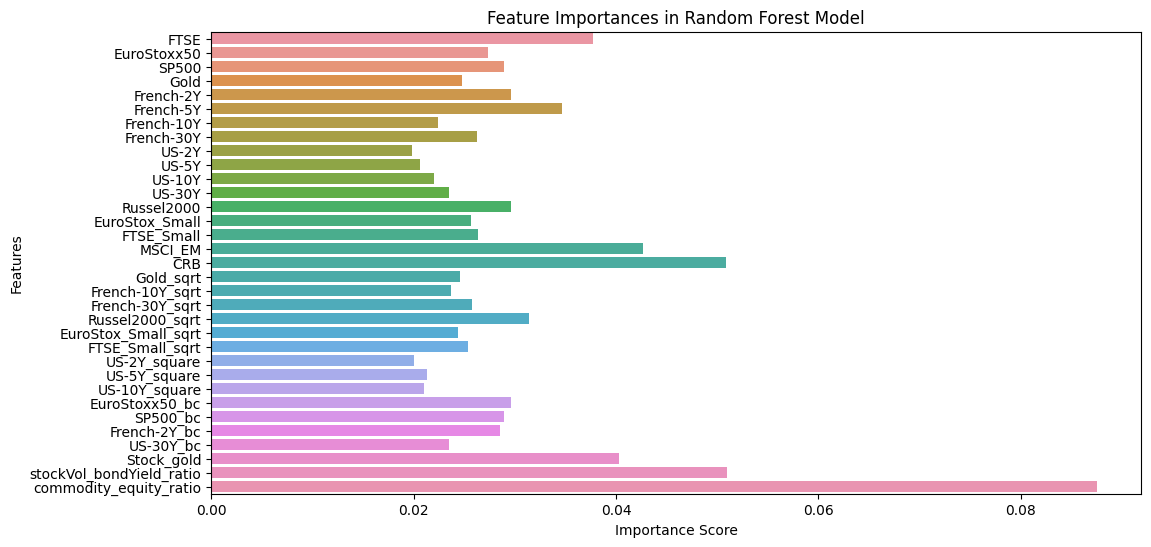

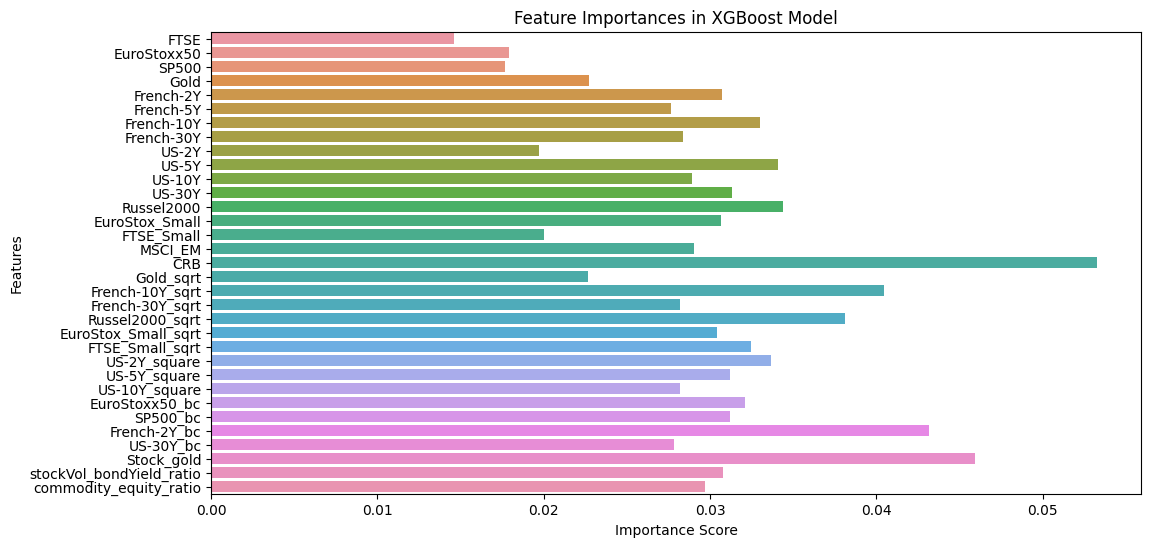

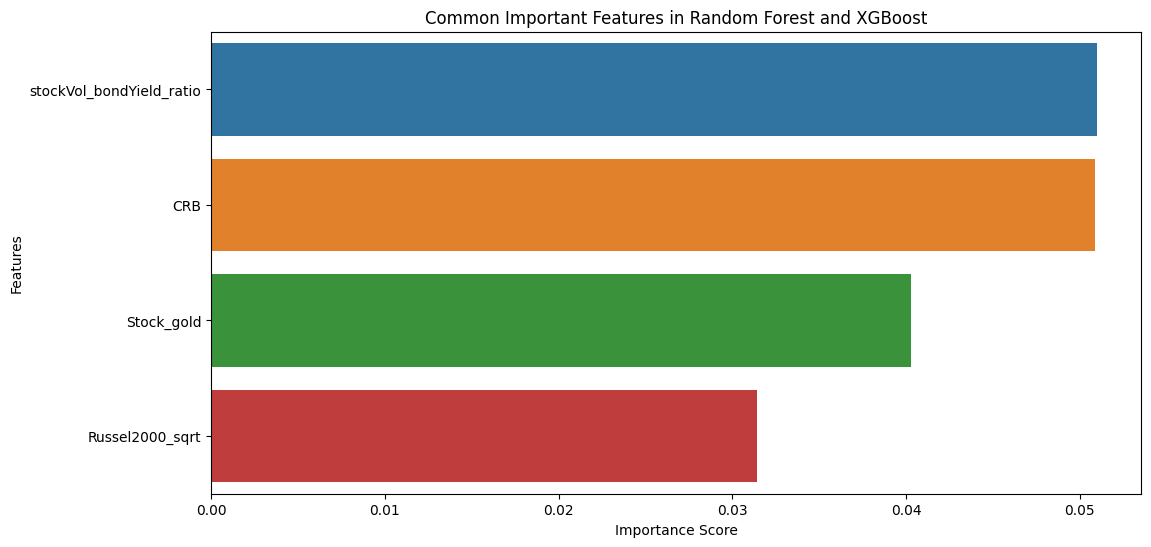

In [61]:
# Visualize the feature importance

model_importances = {
    'Random Forest Model': rf_importances,
    'XGBoost Model': xgb_importances
}

# Plot feature importances for each model
for model_name, importances in model_importances.items():
    plt.figure(figsize=(12, 6))
    sns.barplot(x=importances, y=importances.index)
    plt.title(f'Feature Importances in {model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

# Highlighting the common important features in both models
common_important_features = rf_importances[intersection_important_features].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=common_important_features, y=common_important_features.index)
plt.title('Common Important Features in Random Forest and XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


Feature selection: Remove the features listed in correlation-based potential removal list unless they are deemed important by being in intersection of important features from random forest and xgboost

In [62]:
intersection_important_features = {'CRB', 'Russel2000_sqrt', 'Stock_gold', 'stockVol_bondYield_ratio'}
potential_removal =  {'US-30Y_bc', 'Russel2000', 'SP500_bc', 'French-10Y_sqrt', 'French-2Y', 'Russel2000_sqrt',
                      'EuroStoxx50_bc', 'SP500', 'French-30Y', 'EuroStox_Small', 'FTSE_Small',
                      'US-30Y', 'French-10Y', 'US-5Y', 'US-10Y', 'FTSE_Small_sqrt', 'US-2Y_square',
                      'US-5Y_square', 'Gold', 'French-30Y_sqrt', 'FTSE', 'French-2Y_bc', 'US-10Y_square', 'French-5Y'}

final_columns = [col for col in X_train_df_normalized.columns if col not in potential_removal or col in intersection_important_features]

X_train_df_normalized_select = X_train_df_normalized[final_columns]
X_valid_df_normalized_select = X_valid_df_normalized[final_columns]


In [63]:
X_train_df_normalized_select

,EuroStoxx50,US-2Y,MSCI_EM,CRB,Gold_sqrt,Russel2000_sqrt,EuroStox_Small_sqrt,Stock_gold,stockVol_bondYield_ratio,commodity_equity_ratio
Dates,,,,,,,,,,
1989-02-01,-0.128673,-0.280902,-0.270759,0.099657,0.072847,-0.195233,0.009691,-0.010727,0.240855,-1.467003e+06
1989-02-02,-0.128028,-0.281028,-0.268340,0.100675,0.071475,-0.193962,0.010985,-0.010433,0.239303,-2.395217e+00
1989-02-03,-0.126888,-0.285891,-0.264880,0.095027,0.063754,-0.192187,0.017375,-0.009096,0.222495,5.346085e+00
1989-02-06,-0.125431,-0.282885,-0.262196,0.090591,0.061393,-0.190291,0.019038,-0.008672,0.240095,7.623916e+00
1989-02-07,-0.126556,-0.282003,-0.264369,0.089529,0.072632,-0.190339,0.014981,-0.010361,0.216887,-8.253727e+00
...,...,...,...,...,...,...,...,...,...,...
2006-05-31,0.084327,0.080756,0.271960,0.189465,0.411859,0.155610,0.330631,0.090961,-0.168781,7.151169e-02
2006-06-01,0.086676,0.082745,0.277874,0.193282,0.399020,0.164567,0.336737,0.090088,-0.157436,4.913989e-01
2006-06-02,0.084508,0.087139,0.284730,0.191128,0.394626,0.162191,0.337055,0.089225,-0.206996,7.707444e-01


Before further extracting features for exploring deeper relationship between features and target, we first validate feature performance after adding in new features and feature selection.

First validate with a simpler, less computationally intensive model to quick indicate whether feature engineering is improving the feature prediction ability or not.

In [64]:
from sklearn.metrics import mean_absolute_error

# Train a new model on selected features
model_selected = RandomForestRegressor(max_features = 'auto', min_samples_leaf = 1, min_samples_split = 4, n_estimators = 150)
model_selected.fit(X_train_df_normalized_select, y_train_df)

# Validate the model
y_pred = model_selected.predict(X_valid_df_normalized_select)
mae = mean_absolute_error(y_valid_df, y_pred)

y_pred_origin = rf_model.predict(X_valid_df_normalized)
mae_origin = mean_absolute_error(y_valid_df, y_pred_origin)

print("Mean Absolute Error with origin Features:", mae_origin)
print("Mean Absolute Error. with Selected Features:", mae)


Mean Squared Error with origin Features: 0.49865606887773883
Mean Squared Error with Selected Features: 0.49553812574289713


Conlusion: the selected features improve the model performance by reducing prediction error, so we keep thsoe features and futher extract deeper relationship with target.

Extracting

Since orignal dataset has highly correlated variables, and the new selected features are proved to be relavant to target and reduce the prediction error, we extract base on dataset after feature selection.

In [162]:
# Example Extracting (has errors)
# Name: Annualized volatility in returns
# Description: We are developing an annualized volatility measure for all asset returns, which is a good measure of market turbulence

# def vola(df):
#   volatility = df.pct_change().rolling(window=365).std()*(365**0.5)
#   new_names = [(i,i+'_vol') for i in df.columns.values]
#   volatility.rename(columns = dict(new_names), inplace=True)
#   df = pd.concat((df, volatility), axis=1)
#   return df

# X_train__ = vola(X_train_df_normalized_select); X_test__ = vola(X_valid_df_normalized_select)

X_train_e = X_train_.copy()
X_test_e = X_test_.copy()

check_for_nans(X_test_e)
locate_inf(X_train_e)
# no nan in train and test data, we dont use fillna

def vola(df):
  volatility = df.pct_change().rolling(window=365).std()*(365**0.5)
  new_names = [(i,i+'_vol') for i in df.columns.values]
  volatility.rename(columns = dict(new_names), inplace=True)
  volatility.fillna(0, inplace=True)  # Fill NaNs with 0
  df = pd.concat((df, volatility), axis=1)
  return df

X_train_e = vola(X_train_e); X_test_e = vola(X_test_e)

check_for_nans(X_train_e)
check_for_nans(X_test_e)
# locate_inf(X_train_e)
# na_count = X_train_e.isna().sum()


'The DataFrame does not contain any NaN values.'

Error1: pct_change() calculates the percentage change between the current and a prior element. For the first element of each column, since there is no previous element to compare with, pct_change() results in a NaN.
And, rolling().std() calculates the moving std over a 365 days window size. For the first 365 elements of each column, there aren't enough values to fill the window, resulting in NaN values for the rolling std, causing 365 nan values in each column got from vola.

Solve: instead of fillna after pct_change(), handle NaNs after completing all calculations related to volatility, ensuring that the volatility measure remains as accurate as possible to the original data characteristics. Fill nan with 0, which assumes no change or no additional volatility for the missing data points, which can be a neutral stance in certain analytical contexts.

In [65]:
## Extracting 1
# Name: Exponential Moving Average
# Description: EMA smooth out features fluctuations and highlight more recent trends, which might be more relevant for predicting future movements.

def EMA(df, span=30):
    for col in df.columns:
        df[col + '_EMA'] = df[col].ewm(span=span, adjust=False).mean()
    return df

# Applying EMA

# change df name for later comparison between extract feature and selected feature!

X_train_df_normalized_select = EMA(X_train_df_normalized_select)
X_valid_df_normalized_select = EMA(X_valid_df_normalized_select)

In [67]:
# Extracting 2
# Name: lag of lag_cols
# Description: This is time series analysis, use Time-Series lag features for later LSTM model
# Since the  GRB and Gold_sqrt are highly linear correlated with target, and stockVol_bondYield_ratio and Stock_gold are highly nonlinear correlated with target, we use the lag features of them.

def add_historic_features(df, cols, shifts=3, nan_fill_method='mean'):
    for col in cols:

        # Fill the NaN values based on the chosen method
        if nan_fill_method == 'mean':
            fill_value = df[col].mean()
        elif nan_fill_method == 'median':
            fill_value = df[col].median()
        elif nan_fill_method == 'zero':
            fill_value = 0
        elif nan_fill_method == 'bfill':
            df[col + "_shift" + str(shift)] = df[col + "_shift" + str(shift)].fillna(method='bfill')
            continue

        for shift in np.arange(shifts):
            df[col+"_shift"+str(shift+1)] = df[col].shift(shift + 1).fillna(fill_value)
    return df


lag_cols = ['CRB', 'Gold_sqrt','stockVol_bondYield_ratio','Stock_gold']
X_train_df_normalized_select = add_historic_features(X_train_df_normalized_select, lag_cols)
X_valid_df_normalized_select = add_historic_features(X_valid_df_normalized_select, lag_cols)

In [68]:
## Extracting 3
# Name: Pairwise Correlation Feature
# Description: Stock market indices can be highly correlated, which could indicate how markets move in tandem or diverge.

from itertools import combinations

def pairwise_correlation(df, cols, window=30):
    corr_rolled = df[cols].rolling(window=window).corr()
    pairwise_corr_df = pd.DataFrame(index=df.index)

    # Iterate over unique combinations of columns to extract correlations
    for col1, col2 in combinations(cols, 2):
        col_name = f'corr_{col1}_{col2}'
        pairwise_corr_df[col_name] = corr_rolled[col1].xs(key=col2, level=1)

    # Specify a suffix for columns that overlap
    df = df.join(pairwise_corr_df, rsuffix='_corr')

    return df

X_train_df_normalized_select = pairwise_correlation(X_train_df_normalized_select, cols=['EuroStoxx50', 'EuroStox_Small_sqrt', 'MSCI_EM'])
X_valid_df_normalized_select = pairwise_correlation(X_valid_df_normalized_select, cols=['EuroStoxx50', 'EuroStox_Small_sqrt', 'MSCI_EM'])


# fill na with 0, indicating a neutral value, no correlation.
X_train_df_normalized_select = X_train_df_normalized_select.fillna(0)
X_valid_df_normalized_select = X_valid_df_normalized_select.fillna(0)

In [69]:
X_valid_df_normalized_select.head(-5)

,EuroStoxx50,US-2Y,MSCI_EM,CRB,Gold_sqrt,Russel2000_sqrt,EuroStox_Small_sqrt,Stock_gold,stockVol_bondYield_ratio,commodity_equity_ratio,...,Gold_sqrt_shift3,stockVol_bondYield_ratio_shift1,stockVol_bondYield_ratio_shift2,stockVol_bondYield_ratio_shift3,Stock_gold_shift1,Stock_gold_shift2,Stock_gold_shift3,corr_EuroStoxx50_EuroStox_Small_sqrt,corr_EuroStoxx50_MSCI_EM,corr_EuroStox_Small_sqrt_MSCI_EM
Dates,,,,,,,,,,,,,,,,,,,,,
2006-06-07,0.044781,0.046026,0.142609,0.106309,0.217062,0.084517,0.175987,0.025446,-0.276697,0.321116,...,0.319271,-0.260482,-0.260482,-0.260482,0.035655,0.035655,0.035655,0.000000,0.000000,0.000000
2006-06-08,0.041552,0.046998,0.131458,0.105822,0.209721,0.085169,0.164096,0.023164,-0.207908,0.098231,...,0.319271,-0.276697,-0.260482,-0.260482,0.025446,0.035655,0.035655,0.000000,0.000000,0.000000
2006-06-09,0.043385,0.046459,0.134333,0.103601,0.209620,0.083513,0.167642,0.023540,-0.343007,-0.799038,...,0.319271,-0.207908,-0.276697,-0.260482,0.023164,0.025446,0.035655,0.000000,0.000000,0.000000
2006-06-12,0.042187,0.046261,0.130423,0.107815,0.206206,0.080001,0.164151,0.022467,-0.376342,-1.513412,...,0.217062,-0.343007,-0.207908,-0.276697,0.023540,0.023164,0.025446,0.000000,0.000000,0.000000
2006-06-13,0.040277,0.047444,0.119836,0.104958,0.184970,0.079074,0.154474,0.018774,-0.359235,0.706903,...,0.209721,-0.376342,-0.343007,-0.207908,0.022467,0.023540,0.023164,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-18,0.023304,0.105280,0.157160,0.126694,0.298790,0.115790,0.168584,0.055567,2.921721,-0.156216,...,0.296815,2.182936,2.455648,2.907835,0.054340,0.054195,0.054445,0.661651,0.095385,-0.406150
2017-12-19,0.023007,0.105843,0.158866,0.127915,0.300636,0.115864,0.170091,0.056260,4.997357,21.875379,...,0.297557,2.921721,2.182936,2.455648,0.055567,0.054340,0.054195,0.637590,0.082848,-0.338162
2017-12-20,0.022565,0.106139,0.159652,0.129000,0.302975,0.116583,0.169652,0.056843,10.074681,-1.428414,...,0.297094,4.997357,2.921721,2.182936,0.056260,0.055567,0.054340,0.603666,0.053976,-0.261934


Check nan and inf

In [74]:
check_for_nans(X_train_df_normalized_select)
check_for_inf(X_train_df_normalized_select)
locate_inf(X_train_df_normalized_select)

check_for_nans(X_valid_df_normalized_select)
check_for_inf(X_valid_df_normalized_select)
locate_inf(X_valid_df_normalized_select)

'The DataFrame does not contain any NaN values.'

In [75]:
# Train a new model on selected features
model_extracted = RandomForestRegressor(max_features = 'auto', min_samples_leaf = 1, min_samples_split = 4, n_estimators = 150)
model_extracted.fit(X_train_df_normalized_select, y_train_df)

# Validate the model
y_pred_extract = model_extracted.predict(X_valid_df_normalized_select)
mae_extract = mean_absolute_error(y_valid_df, y_pred_extract)

print("Mean Absolute Error with Selected Features:", mae_extract)

Mean Squared Error with Selected Features: 0.49895858096570483


The MAE after extracting 0.49896 is higher than MAE after selection 0.4955, it indicates feature extracting includes extra noise. However, the extracted data is derived after feature selection which has been proved improving model performance, so we will use extracted data for LSTM model trainig, which can automatically learn to reduce noise and forget some noise.

## Deep Learning Binary Classification

* For the deep learning model you can perform new data preprocessing methods and new feature engineering that are better suited to neural networks. You can also use all or some of the features you developed above (most features work in deep learning models as long as they are normalized).
* It is very hard to predict the stock price, so in my grading I will look more at the quality of the model you process (e.g., that there is no data leakage, that you performed some hyperparameter tuning).
* Make sure that you switch your GPU on, you have access to it on Colab. The training stage also takes long, you might want to use a smaller amount of data, or fewer epochs at first to speed up your development process.
* After your training is done, you don't have to save your model, but you do have to print the performance of your model. You can report two metrics the ROC(AUC) and the Accuracy against the test set.
* Also remember to set the random seed (random state) so that when I run your software, I get similar results (the results doesn't have to be exactely the same).
* You can choose any type of deep learning archetecture, e.g., LSTM, GRU, CNN, it is up to you.
* Remember that this section is less that 25% of the grade, so don't waste your time here.
* And lastly, remember this is the stock market, so it is **difficult** to have an accuracy above 50%, good luck!

Make each feature in the same scale [0, 1] for LSTM model process

In [76]:
from sklearn.preprocessing import MinMaxScaler

scaler_mm = MinMaxScaler()

train_columns = X_train_df_normalized_select.columns
train_index = X_train_df_normalized_select.index
X_train_df_normalized_select = scaler_mm.fit_transform(X_train_df_normalized_select)
X_train_df_normalized_select = pd.DataFrame(X_train_df_normalized_select, columns=train_columns, index=train_index)

valid_columns = X_valid_df_normalized_select.columns
valid_index = X_valid_df_normalized_select.index
X_valid_df_normalized_select = scaler_mm.transform(X_valid_df_normalized_select)
X_valid_df_normalized_select = pd.DataFrame(X_valid_df_normalized_select, columns=valid_columns, index=valid_index)


In [77]:
x_cols = X_train_df_normalized_select.columns.tolist()
y_cols = ["target"]

# Resetting the index in this way keeps the data in the same order but replaces the time index with a simple integer index, which might simplify data handling in PyTorch's DataLoader.
X_train_df_normalized_select = X_train_df_normalized_select.reset_index(drop=True)
y_train_df = y_train_df.reset_index(drop=True)
X_train_lstm = X_train_df_normalized_select.join(y_train_df, how='left')

X_valid_df_normalized_select = X_valid_df_normalized_select.reset_index(drop=True)
y_valid_df = y_valid_df.reset_index(drop=True)
X_valid_lstm = X_valid_df_normalized_select.join(y_valid_df, how='left')

In [78]:
X_train_lstm.head()

,EuroStoxx50,US-2Y,MSCI_EM,CRB,Gold_sqrt,Russel2000_sqrt,EuroStox_Small_sqrt,Stock_gold,stockVol_bondYield_ratio,commodity_equity_ratio,...,stockVol_bondYield_ratio_shift1,stockVol_bondYield_ratio_shift2,stockVol_bondYield_ratio_shift3,Stock_gold_shift1,Stock_gold_shift2,Stock_gold_shift3,corr_EuroStoxx50_EuroStox_Small_sqrt,corr_EuroStoxx50_MSCI_EM,corr_EuroStox_Small_sqrt_MSCI_EM,target
0,0.189395,0.014036,0.040041,0.494294,0.653117,0.124475,0.507944,0.409082,0.878254,0.999778,...,0.877945,0.877945,0.877945,0.399642,0.399642,0.399642,0.492739,0.498266,0.48586,0
1,0.190412,0.013866,0.042561,0.495301,0.651805,0.127068,0.509288,0.410720,0.878254,0.999999,...,0.878254,0.877945,0.877945,0.409082,0.399642,0.399642,0.492739,0.498266,0.48586,1
2,0.192208,0.007355,0.046166,0.489713,0.644418,0.130690,0.515921,0.418169,0.878246,0.999999,...,0.878254,0.878254,0.877945,0.410720,0.409082,0.399642,0.492739,0.498266,0.48586,0
3,0.194504,0.011380,0.048963,0.485324,0.642160,0.134559,0.517647,0.420534,0.878254,0.999999,...,0.878246,0.878254,0.878254,0.418169,0.410720,0.409082,0.492739,0.498266,0.48586,1
4,0.192730,0.012561,0.046699,0.484273,0.652913,0.134461,0.513435,0.411122,0.878243,0.999999,...,0.878254,0.878246,0.878254,0.420534,0.418169,0.410720,0.492739,0.498266,0.48586,0


Tensor Database

In [79]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class CustomDataset(Dataset):
   # sequence_length: key for LSTM handl and learn from sequences of data, and thus discover effect of time dependency in time series
    def __init__(self, dataframe, x_cols, y_cols=None, sequence_length=20):
        self.dataframe = dataframe
        self.x_cols = x_cols
        self.y_cols = y_cols
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.dataframe) - self.sequence_length + 1

    def __getitem__(self, idx):
        x = self.dataframe.iloc[idx:idx+self.sequence_length][self.x_cols]
        y = self.dataframe.iloc[idx+self.sequence_length-1][self.y_cols]

        x_tensor = torch.tensor(x.values, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)

        return x_tensor, y_tensor


In [80]:
def get_dataloaders(train_df, valid_df, x_cols, y_cols=None, batch_size=100):

    # Create CustomDataset instances
    train_dataset = CustomDataset(dataframe=train_df, x_cols=x_cols, y_cols=y_cols)
    valid_dataset = CustomDataset(dataframe=valid_df, x_cols=x_cols, y_cols=y_cols)

    # Create DataLoader instances
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_dataloader, valid_dataloader

train_dataloader, valid_dataloader = get_dataloaders(X_train_lstm, X_valid_lstm, x_cols, y_cols, batch_size=50)

In [81]:
# Iterate through the DataLoader to get the first batch
first_batch = next(iter(train_dataloader))
X, y = first_batch

# Print shapes
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# The shape shows [batch_size, sequence, features]

Shape of X: torch.Size([50, 20, 35])
Shape of y: torch.Size([50, 1])


LSTM Model with Attention net and Guassian Noise

In [83]:
features = 15

In [84]:
class LSTMwithAttention(nn.Module):
    def __init__(self, input_size=35, hidden_layer_size = 30, output_size=1, num_layers=2, noise_stddev=0.2):
        super().__init__()

        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.noise_stddev = noise_stddev
        self.batch_size = 1

        # Kernel: expects the input to have a size (length) of at least 10 along the channel dimension
        self.conv1d = nn.Conv1d(in_channels = 35, out_channels = features, kernel_size=20) # kernel_size: same size as time sequence in lstm
        self.lstm = nn.LSTM(features, hidden_layer_size, num_layers, dropout=0.2)

        layers = [
                nn.Linear(hidden_layer_size, hidden_layer_size),
                # nn.Linear(hidden_layer_size, hidden_layer_size),
                # nn.Linear(hidden_layer_size, output_size)
                nn.Linear(hidden_layer_size, 50)  # Output one value per time step, here is 50 beause one time step, there is 50 batches work at the same time
                ]

        self.linear_layers = nn.Sequential(*layers)

        init_rnn(self.lstm, 'xavier')
        self.dropout = nn.Dropout(0.5)
        self.attn_weights = None

    def attention_net(self, lstm_output, final_state):
        lstm_output = lstm_output.permute(1, 0, 2)  # [batch_size, sequence_length, features]
        # hidden = final_state.view(-1, self.hidden_layer_size, self.num_layers)

        hidden = final_state[-1,:,:]  # Take the last layer hidden state [batch_size, hidden_size]
        hidden = hidden.unsqueeze(2)  # [batch_size, hidden_size, 1]

        self.attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)

        soft_attn_weights = torch.tanh(self.attn_weights)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context

    def forward(self, input_seq):
        input_seq = input_seq.permute(0, 2, 1)
        input_seq = self.conv1d(input_seq)   # 1D convolutional layer expected shape: [batch_size, channels, length]
        input_seq = input_seq[:, :, :50]
        input_seq = input_seq.permute(2, 0, 1)   # tensor expectde shape: [sequence_length, batch_size, features]

        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(len(input_seq[0]), 1, features))

        if self.training:
          noise = torch.randn_like(lstm_out) * self.noise_stddev
          lstm_out = lstm_out + noise

        attn_output = self.attention_net(lstm_out, self.hidden_cell[0])

        out = self.linear_layers(attn_output.view(-1, self.hidden_layer_size))
        out = torch.tanh(out)

        return out.view(50, 1)
        # return out[-1]

def init_rnn(x, type='uniform'):
    for layer in x._all_weights:
        for w in layer:
            if 'weight' in w:
                if type == 'xavier':
                    init.xavier_normal_(getattr(x, w))
                elif type == 'uniform':
                    stdv = 1.0 / (getattr(x, w).size(-1))**0.5
                    init.uniform_(getattr(x, w), -stdv, stdv)
                elif type == 'normal':
                    stdv = 1.0 / (getattr(x, w).size(-1))**0.5
                    init.normal_(getattr(x, w), 0.0, stdv)
                else:
                    raise ValueError

In [85]:
model = LSTMwithAttention()

Train Model

In [86]:
import pandas as pd
import time
from torch.utils.data import DataLoader

# Assuming model, optimizer, scheduler, dataloaders are already defined

def train_loop(dataloader, model, loss_fn, optimizer, shortcut=0):
  # Setting the model to training mode:
    model.train()
    train_loss = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):

        pred = model(X)

        # Check for NaN in predictions
        if torch.isnan(pred).any():
            raise ValueError(f"NaN detected in predictions of batch {batch}")

        loss = loss_fn(pred, y)

        # Check for NaN in loss
        if torch.isnan(loss):
            raise ValueError(f"NaN detected in loss of batch {batch}")

        train_loss += loss.item()

        # Backpropagation
        # compute the gradients of the loss function with respect to the model's parameters,
        # and gradients are used to update the model's weights.
        loss.backward()

        # update the model's weights based on the gradients computed during backpropagation.
        optimizer.step()

        # ensure that each batch's gradients are computed afresh
        # In the training loop, gradients are accumulated by default (i.e., they are summed up) over batches.
        # so we reset them at the beginning of each batch.
        optimizer.zero_grad()

        # Check for NaN in input and output
        if torch.isnan(X).any() or torch.isnan(y).any():
            raise ValueError(f"NaN detected in batch {batch}")

        if pred.std() < 0.000001:
            print("WARNING: std() is zero, stopping")
            break

        if batch % 10 == 0:  # Adjust this value to change the frequency of printing
            print(f"Train Finished {batch}/{num_batches} batches. Current loss: {loss.item()}")

        if shortcut > 0 and batch == shortcut:
            # return train_loss.detach().cpu().numpy() / shortcut
            return train_loss / shortcut

    return train_loss / num_batches

def validation_loop(dataloader, model, loss_fn):

  model.eval()
  valid_loss = 0
  num_batches = len(dataloader)

  with torch.no_grad():
      for batch, (X, y) in enumerate(dataloader):

          pred = model(X)
          loss = loss_fn(pred, y)
          valid_loss += loss.item()

          if batch % 10 == 0:  # Print every 100 batches
              print(f"Valid Finished {batch}/{num_batches} batches. Current validation loss: {loss.item()}")

  return valid_loss / num_batches


In [87]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.00001):
        self.best_model = None
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def get_best_model(self):
        return self.best_model

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            print(f"New best loss: {validation_loss:>4f}")
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.best_model = model
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [88]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.5, verbose=True)
early_stopper = EarlyStopper(patience=15, min_delta=0.0001)

loss_fn = nn.L1Loss() # MAE error

In [89]:
# Problem: train_loss = train_loop(train_dataloader, model, loss_fn, optimizer) has valueerror: Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
# solve:
# 1. change the dataset shape of input train_dataloader in train_loop functin into 2D, still get error
# 2. change the return dataset from CustomDataset into 2D, which return train_dataloader, still get error
# 3. remove transform parameter from class CustomDataset and get_dataloaders, then run the tensor, there is no shape error anymore.

from google.colab import files

# Training loop
history = pd.DataFrame([], columns=["epoch", "train_loss", "valid_loss", "lr"])
t1 = time.time()

for epoch in range(25):
    print(f"Epoch {epoch + 1:>3d}", end=" ")

    # Training
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    print(f"Train: {train_loss:>5f}", end=" ")

    # Validation
    # The validation loop (validation_loop) is included after the training loop in each epoch to evaluate the model on the validation dataset.
    valid_loss = validation_loop(valid_dataloader, model, loss_fn)
    print(f"| Valid: {valid_loss:>5f}", end=" ")

    # Adjust learning rate based on validation loss
    # the learning rate adjustment is part of the overall training process
    # The scheduler make decisions about adjusting the learning rate from the validation loss
    scheduler.step(valid_loss)

    # Early stopping check
    # Early stopping checks the validation loss for improvement.
    if early_stopper.early_stop(valid_loss, model):
        print("\nEarly stopping triggered.")
        break

    # Save history
    history.loc[len(history), :] = [epoch + 1, train_loss, valid_loss, optimizer.param_groups[0]['lr']]

    # Model Checkpointing
    if epoch % 2 == 0:
        model_filename = f'checkpoint_epoch_{epoch}.pth'
        torch.save(model.state_dict(), model_filename)

    # Time check
    if time.time() - t1 > 60 * 60 * 8:
        print("\nTime limit exceeded.")
        break

# Restoring the best model for test evaluation
best_model = early_stopper.get_best_model() if early_stopper.early_stop(valid_loss, model) else model

# Save the best model for later test df
best_model_filename = 'best_model.pth'
torch.save(best_model.state_dict(), best_model_filename)   # saves the file to the current working directory of the environment

try:
    files.download(best_model_filename)   # downloads the file from the Colab VM to local machine's download folder
except Exception as e:
    print(f"Error downloading the file: {e}")

# Save history to file (optional)
# history.to_csv('training_history.csv', index=False)

# monitoring training progress and for analysis after training.
history


Epoch   1 Train Finished 0/90 batches. Current loss: 0.6609748005867004
Train Finished 10/90 batches. Current loss: 0.5353104472160339
Train Finished 20/90 batches. Current loss: 0.5226184725761414
Train Finished 30/90 batches. Current loss: 0.5794044137001038
Train Finished 40/90 batches. Current loss: 0.5293062925338745
Train Finished 50/90 batches. Current loss: 0.5175600647926331
Train Finished 60/90 batches. Current loss: 0.4511868357658386
Train Finished 70/90 batches. Current loss: 0.4450916647911072
Train Finished 80/90 batches. Current loss: 0.5400922298431396
Train: 0.527029 Valid Finished 0/59 batches. Current validation loss: 0.5142509341239929
Valid Finished 10/59 batches. Current validation loss: 0.4800427556037903
Valid Finished 20/59 batches. Current validation loss: 0.4588664770126343
Valid Finished 30/59 batches. Current validation loss: 0.43865957856178284
Valid Finished 40/59 batches. Current validation loss: 0.5356944799423218
Valid Finished 50/59 batches. Current 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,epoch,train_loss,valid_loss,lr
0,1,0.527029,0.518125,0.001
1,2,0.502499,0.485285,0.001
2,3,0.483376,0.481039,0.001
3,4,0.482786,0.48111,0.001
4,5,0.482798,0.482535,0.001
5,6,0.481506,0.493414,0.001
6,7,0.478012,0.48183,0.001
7,8,0.478379,0.497364,0.001
8,9,0.470431,0.483744,0.001
9,10,0.474028,0.491582,0.001


The validation error initially decreased below the training error but subsequently remained consistently higher as the number of epochs increased, suggesting potential overfitting in the model.

To address this, the number of output features in the convolution layer was reduced from 20 to 15, yet the validation error continued to exceed the training error. Further adjustments included reducing the LSTM model's layers from five to three, aiming to simplify the model's complexity. Despite these modifications, the validation error persisted, hovering around 4% above the training error.

Subsequent efforts involved altering the noise level in the data preprocessing. Removing the noise unexpectedly led to an even greater disparity between the training and validation errors. Consequently, the noise level was increased from 0.1 to 0.2, yet this adjustment also failed to yield the desired effect.

In conclusion, the model and its data preprocessing techniques require more in-depth analysis and refinement. Improving the model's generalization capabilities and enhancing its predictive accuracy remains a priority, necessitating further investigation and optimization efforts.


Nest, Use the best trained model for making predictions on test data

In [90]:
X_test.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
Dates,,,,,,,,,,,,,,,,,
2018-01-01,7687.77,3503.964,2673.61,1303.46,91.743,149.389,208.563,289.210,124.281,147.721,149.160,173.504,1535.51,266.257,5911.89,1157.545,432.45
2018-01-02,7648.10,3490.187,2695.81,1313.10,91.737,149.245,208.007,287.158,124.204,147.443,148.451,171.096,1550.01,267.068,5897.83,1177.978,434.33
2018-01-03,7671.11,3509.882,2713.06,1316.26,91.744,149.248,208.353,288.086,124.184,147.489,148.711,172.016,1552.58,268.464,5925.68,1184.215,435.13
2018-01-04,7695.88,3568.884,2723.99,1317.88,91.703,149.138,208.545,290.390,124.126,147.327,148.616,171.907,1555.72,271.457,5948.35,1192.556,436.71
2018-01-05,7724.22,3607.633,2743.15,1319.36,91.693,149.209,208.447,289.670,124.106,147.211,148.309,171.095,1560.01,273.509,5975.58,1201.006,436.60


Imply same process to test data as previously did to train data

In [91]:
# Transforming
X_test = sqrt(X_test, cols_sqrt)
X_test = square(X_test, cols_squre)
X_test = boxcox(X_test, cols_boxcox)

X_test_scaled = scaler.transform(X_test)
X_test_df_normalized = normalize(X_test_scaled, norm='l2')
X_test_df_normalized = pd.DataFrame(X_test_df_normalized, columns=X_test.columns, index=X_test.index)

# Interacting
X_test_df_normalized = stock_gold(X_test_df_normalized)
X_test_df_normalized = stock_vs_bond(X_test_df_normalized)
X_test_df_normalized = commodity_impact_on_equities(X_test_df_normalized)

fillmean(X_test_df_normalized, ['commodity_equity_ratio'])

# Mapping
X_test_df_normalized_select = X_test_df_normalized[final_columns]

# Extracting
X_test_df_normalized_select = EMA(X_test_df_normalized_select)
X_test_df_normalized_select = add_historic_features(X_test_df_normalized_select, lag_cols)
X_test_df_normalized_select = pairwise_correlation(X_test_df_normalized_select, cols=['EuroStoxx50', 'EuroStox_Small_sqrt', 'MSCI_EM'])
X_test_df_normalized_select = X_test_df_normalized_select.fillna(0)

# make old and new features to same sacle
test_columns = X_test_df_normalized_select.columns
test_index = X_test_df_normalized_select.index
X_test_df_normalized_select = scaler_mm.transform(X_test_df_normalized_select)
X_test_df_normalized_select = pd.DataFrame(X_test_df_normalized_select, columns=test_columns, index=test_index)

# prepare for tensor
X_test_df_normalized_select = X_test_df_normalized_select.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_test_lstm = X_test_df_normalized_select.join(y_test, how='left')

# Tensor Dataloader
test_dataset = CustomDataset(dataframe=X_test_lstm, x_cols=x_cols, y_cols=y_cols)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False, drop_last=True)



In [92]:
first_batch = next(iter(test_dataloader))
X, y = first_batch

# Print shapes
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: torch.Size([50, 20, 35])
Shape of y: torch.Size([50, 1])


In [93]:
# use the best trained model stored in colab
model = LSTMwithAttention()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

LSTMwithAttention(
  (conv1d): Conv1d(35, 15, kernel_size=(20,), stride=(1,))
  (lstm): LSTM(15, 30, num_layers=2, dropout=0.2)
  (linear_layers): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=50, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [94]:
# Make predictions
all_predictions = []

with torch.no_grad():
    for X_batch, _ in test_dataloader:
        batch_predictions = model(X_batch)
        all_predictions.append(batch_predictions)

# Concatenate all batch predictions
all_predictions = torch.cat(all_predictions, dim=0)

In [95]:
# Model performance
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
mae = torch.mean(torch.abs(all_predictions - y_test_tensor))
print(f'Mean Absolute Error: {mae.item()}')


Mean Absolute Error: 0.46957287192344666


 The Mean Absolute Error of test set is 46.96% using best trained LSTM model.